# Calibration
[OpenCV docs](https://docs.opencv.org/4.x/da/d13/tutorial_aruco_calibration.html)

In [2]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pickle

%matplotlib inline

In [3]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_7X7_50)
board = aruco.CharucoBoard_create(7, 5, 1, .8, aruco_dict)
imboard = board.draw((2000, 2000))
cv2.imshow("image", imboard)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
datadir_1 = "./calib_cam_1/"
images_1 = np.array([datadir_1 + f for f in os.listdir(datadir_1) if f.endswith(".png") ])
order_1 = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_1])
images_1 = images_1[order_1]
print(len(images_1))
images_1

28


array(['./calib_cam_1/0.png', './calib_cam_1/1.png',
       './calib_cam_1/2.png', './calib_cam_1/3.png',
       './calib_cam_1/5.png', './calib_cam_1/6.png',
       './calib_cam_1/7.png', './calib_cam_1/8.png',
       './calib_cam_1/9.png', './calib_cam_1/10.png',
       './calib_cam_1/11.png', './calib_cam_1/12.png',
       './calib_cam_1/13.png', './calib_cam_1/14.png',
       './calib_cam_1/15.png', './calib_cam_1/16.png',
       './calib_cam_1/17.png', './calib_cam_1/18.png',
       './calib_cam_1/19.png', './calib_cam_1/20.png',
       './calib_cam_1/21.png', './calib_cam_1/22.png',
       './calib_cam_1/23.png', './calib_cam_1/24.png',
       './calib_cam_1/25.png', './calib_cam_1/26.png',
       './calib_cam_1/27.png', './calib_cam_1/28.png'], dtype='<U20')

In [5]:
datadir_2 = "./calib_cam_1/02_08/"
images_2 = np.array([datadir_2 + f for f in os.listdir(datadir_2) if f.endswith(".png") ])
order_2 = np.argsort([int(p.split(".")[1].split("/")[-1]) for p in images_2])
images_2 = images_2[order_2]
print(len(images_2))
images_2

113


array(['./calib_cam_1/02_08/0.png', './calib_cam_1/02_08/1.png',
       './calib_cam_1/02_08/2.png', './calib_cam_1/02_08/3.png',
       './calib_cam_1/02_08/4.png', './calib_cam_1/02_08/5.png',
       './calib_cam_1/02_08/6.png', './calib_cam_1/02_08/7.png',
       './calib_cam_1/02_08/8.png', './calib_cam_1/02_08/9.png',
       './calib_cam_1/02_08/10.png', './calib_cam_1/02_08/11.png',
       './calib_cam_1/02_08/12.png', './calib_cam_1/02_08/13.png',
       './calib_cam_1/02_08/14.png', './calib_cam_1/02_08/15.png',
       './calib_cam_1/02_08/16.png', './calib_cam_1/02_08/17.png',
       './calib_cam_1/02_08/18.png', './calib_cam_1/02_08/19.png',
       './calib_cam_1/02_08/20.png', './calib_cam_1/02_08/21.png',
       './calib_cam_1/02_08/22.png', './calib_cam_1/02_08/23.png',
       './calib_cam_1/02_08/24.png', './calib_cam_1/02_08/25.png',
       './calib_cam_1/02_08/26.png', './calib_cam_1/02_08/27.png',
       './calib_cam_1/02_08/28.png', './calib_cam_1/02_08/29.png',
     

In [6]:
images = np.concatenate((images_1, images_2), axis=None)
len(images)

141

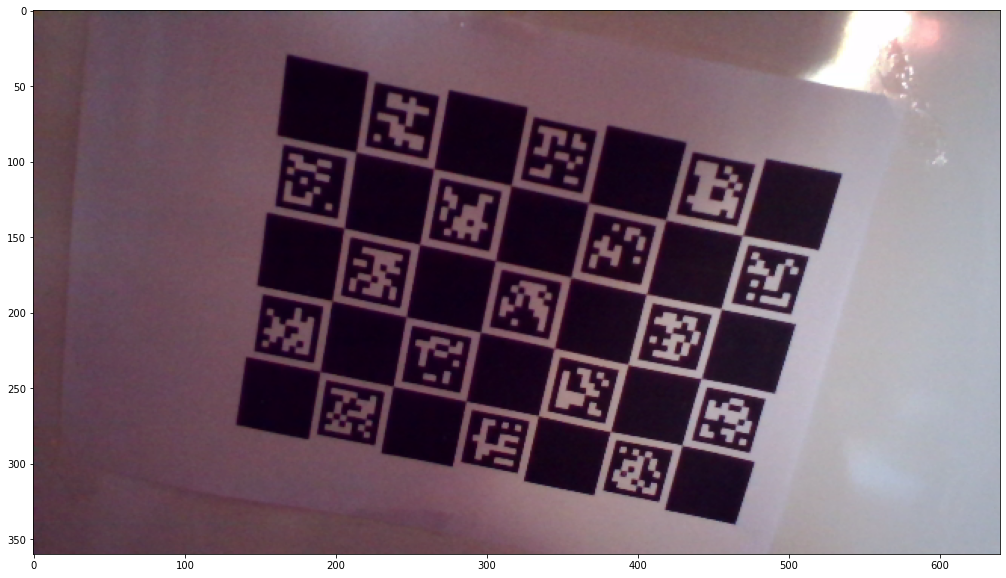

In [7]:
im = PIL.Image.open(images[15])
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
plt.imshow(im)
#ax.axis('off')
plt.show()

In [8]:
img = cv2.imread(images[0], cv2.IMREAD_COLOR)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [9]:
def read_chessboards(images, aruco_dict, board):
    """
    Charuco base pose estimation.
    """
    print("POSE ESTIMATION STARTS:")
    allCorners = []
    allIds = []
    decimator = 0

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # objp = np.zeros(((5-1)*(7-1),3), np.float32)
    # objp[:,:2] = np.mgrid[0:(7-1),0:(5-1)].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    # objpoints = [] # 3d point in real world space
    # imgpoints = [] # 2d points in image plane.

    # SUB PIXEL CORNER DETECTION CRITERION
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)

    for im in images:
        print("=> Processing image {0}".format(im))
        frame = cv2.imread(im)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#ga061ee5b694d30fa2258dd4f13dc98129)
        corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, aruco_dict)


        if len(corners)>0:
            print(f"Number of markers detected: {len(corners)}")            
            # SUB PIXEL DETECTION (https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e)
            for corner in corners:
                cv2.cornerSubPix(gray, corner,
                                 winSize = (3,3), # The shorter the window the higher the accuracy
                                 zeroZone = (-1,-1),
                                 criteria = criteria)
            # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1)
            res2 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
            if res2[1] is not None and res2[2] is not None and len(res2[1])>3 and decimator%1==0:
                allCorners.append(res2[1])
                allIds.append(res2[2])

                # imgpoints.append(res2[1])
                # objpoints.append(objp)

        decimator+=1

    imsize = gray.shape

    # return allCorners,allIds,imsize,imgpoints,objpoints
    return allCorners,allIds,imsize

In [10]:
# allCorners,allIds,imsize,imgpoints,objpoints = read_chessboards(images, aruco_dict, board)
allCorners,allIds,imsize = read_chessboards(images, aruco_dict, board)

POSE ESTIMATION STARTS:
=> Processing image ./calib_cam_1/0.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/1.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/2.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/3.png
Number of markers detected: 16
=> Processing image ./calib_cam_1/5.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/6.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/7.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/8.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/9.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/10.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/11.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/12.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/13.png
Number of markers detected: 17
=> Processing image ./calib_cam_1/14.png
Number o

In [11]:
def calibrate_camera(allCorners, allIds, imsize):
    """
    Calibrates the camera using the dected corners.
    """
    print("CAMERA CALIBRATION")

    cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                                 [    0., 1000., imsize[1]/2.],
                                 [    0.,    0.,           1.]])

    distCoeffsInit = np.zeros((5,1))
    flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO)
    #flags = (cv2.CALIB_RATIONAL_MODEL)
    # Documentation (https://docs.opencv.org/4.x/d9/d6a/group__aruco.html#gadcc5dc30c9ad33dcf839e84e8638dcd1)
    (ret, camera_matrix, distortion_coefficients0,
     rotation_vectors, translation_vectors,
     stdDeviationsIntrinsics, stdDeviationsExtrinsics,
     perViewErrors) = cv2.aruco.calibrateCameraCharucoExtended(
                      charucoCorners=allCorners,
                      charucoIds=allIds,
                      board=board,
                      imageSize=imsize,
                      cameraMatrix=cameraMatrixInit,
                      distCoeffs=distCoeffsInit,
                      flags=flags,
                      criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9))

    return ret, camera_matrix, distortion_coefficients0, rotation_vectors, translation_vectors

In [12]:
%time ret, mtx, dist, rvecs, tvecs = calibrate_camera(allCorners,allIds,imsize)

CAMERA CALIBRATION
CPU times: user 5min 31s, sys: 73.1 ms, total: 5min 31s
Wall time: 5min 31s


In [13]:
print(f"Reprojection error: {ret}")

Reprojection error: 0.8367005496331931


In [14]:
print(f"Calibration matrix:\n{mtx}")

Calibration matrix:
[[600.69561103   0.         328.12680703]
 [  0.         600.69561103 185.19274128]
 [  0.           0.           1.        ]]


In [15]:
print(f"Distortion coefficients:\n{dist}")

Distortion coefficients:
[[ 2.57869330e+01]
 [-1.19540971e+02]
 [-1.37320676e-04]
 [ 4.15196700e-03]
 [-5.03284240e+01]
 [ 2.58069579e+01]
 [-1.21166086e+02]
 [-4.36486414e+01]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]


In [16]:
# Reprojection error
# Only used for calibration with traditional chessboards
if False:
    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        # print((imgpoints[i].shape))
        # print((imgpoints2.shape))
        if imgpoints[i].shape != imgpoints2.shape:
            print(f"Not all markers detected in img {i}")
            continue
        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
        # print(f"Error {i}: {error}")
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )

./calib_cam_1/21.png


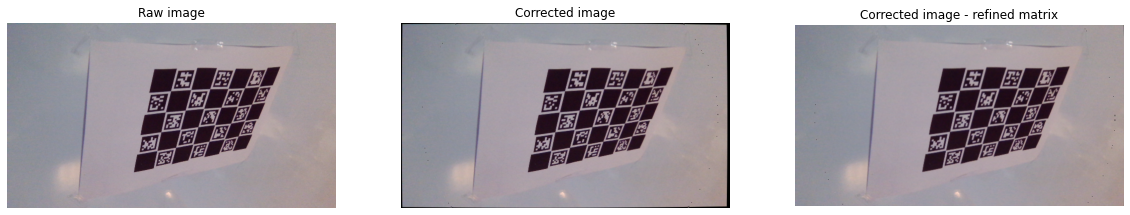

In [46]:
# Refining camera matrix and check calibration results
i=20 #75 # select image id
print(images[i])
plt.figure(figsize=(20,10))
frame = cv2.imread(images[i])
img_undist = cv2.undistort(frame, mtx, dist, None, None)

h, w = frame.shape[:2]
new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
img_undist_fine = cv2.undistort(frame, mtx, dist, None, new_mtx)
# crop the image
x, y, w, h = roi
img_undist_fine = img_undist_fine[y:y+h, x:x+w]

plt.subplot(1,3,1)
plt.imshow(frame)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,3,2)
plt.imshow(img_undist)
plt.title("Corrected image")
plt.axis("off")
plt.subplot(1,3,3)
plt.imshow(img_undist_fine)
plt.title("Corrected image - refined matrix")
plt.axis("off")
plt.show()

In [47]:
print(f"Matrix coefs:\n{mtx}\n")
print(f"Refined matrix coefs:\n{new_mtx}\n")

Matrix coefs:
[[600.69561103   0.         328.12680703]
 [  0.         600.69561103 185.19274128]
 [  0.           0.           1.        ]]

Refined matrix coefs:
[[606.14428711   0.         329.44357864]
 [  0.         600.54907227 184.61361011]
 [  0.           0.           1.        ]]



In [48]:
import pickle
import os

imgdir = "./calib_params_1/"

# Check whether the specified path exists or not
isExist = os.path.exists(imgdir)

if not isExist:
  os.makedirs(imgdir)
  
pickle.dump(mtx, open('./calib_params_1/matrix.pickle', 'wb'))
pickle.dump(new_mtx, open('./calib_params_1/refined_matrix.pickle', 'wb'))
pickle.dump(dist, open('./calib_params_1/dist_coef.pickle', 'wb'))
pickle.dump(rvecs, open('./calib_params_1/rotation_vectors.pickle', 'wb'))
pickle.dump(tvecs, open('./calib_params_1/translation_vectors.pickle', 'wb'))
pickle.dump(ret, open('./calib_params_1/reprojection_error.pickle', 'wb'))

### Use of camera calibration to estimate 3D translation and rotation of each marker on a scene

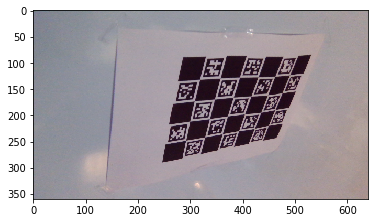

In [49]:
# frame = cv2.imread("./calib_cam_1/02_08/100.png")
#frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
plt.figure()
plt.imshow(frame, interpolation = "nearest")
plt.show()

In [55]:
# Post processing
# gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
gray = cv2.cvtColor(img_undist_fine, cv2.COLOR_BGR2GRAY)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict,
                                                      parameters=parameters)
                                                      
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
# frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
frame_markers = aruco.drawDetectedMarkers(img_undist_fine.copy(), corners, ids)

retval, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(corners, ids, img_undist_fine.copy(), board, cameraMatrix=new_mtx, distCoeffs=dist)
frame_corners = aruco.drawDetectedCornersCharuco(img_undist_fine.copy(), charucoCorners, charucoIds)

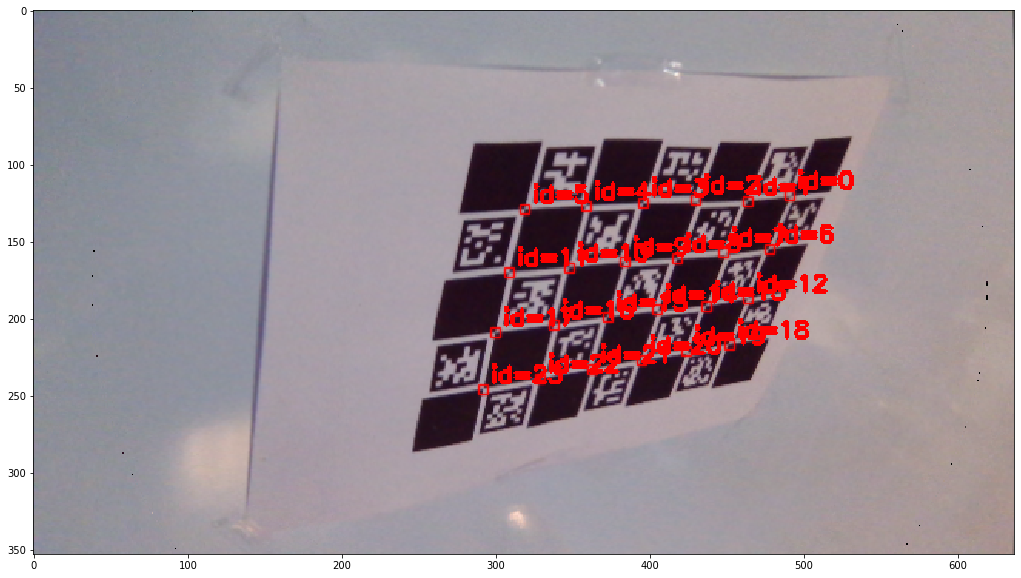

In [56]:
# Results
plt.figure(figsize=(20,10))
plt.imshow(frame_corners, interpolation = "nearest")

plt.show()

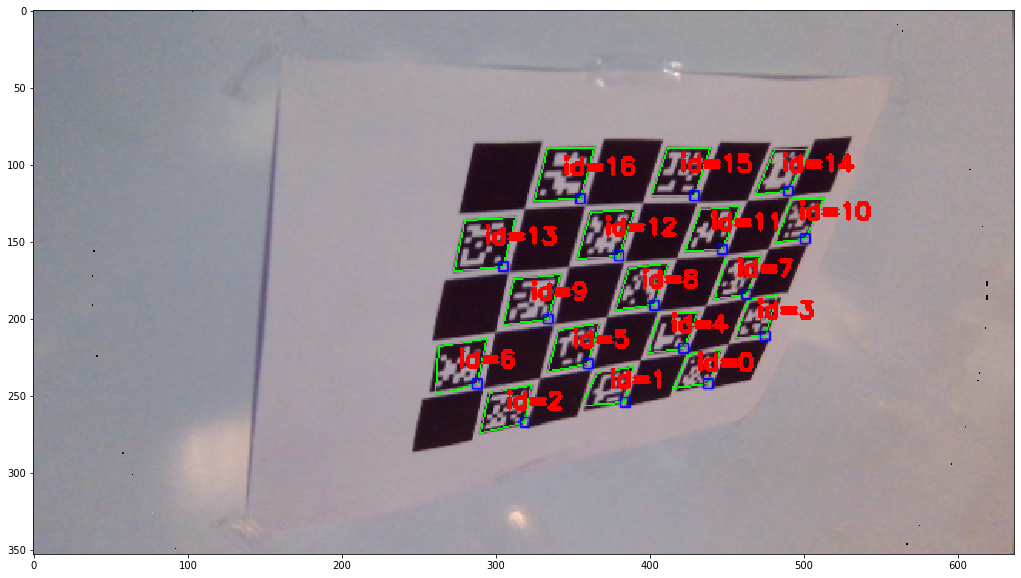

In [51]:
# Results
plt.figure(figsize=(20,10))
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

#### Add local axis on each marker

In [51]:
size_of_marker =  0.0285 # side lenght of the marker in meter
# rvecs, tvecs, _objPoints = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
rvecs, tvecs, _objPoints = aruco.estimatePoseSingleMarkers(corners, size_of_marker , new_mtx, dist)

In [52]:
length_of_axis = 0.1
# imaxis = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
imaxis = aruco.drawDetectedMarkers(img_undist_fine.copy(), corners, ids)

for i in range(len(tvecs)):
    # imaxis = aruco.drawAxis(imaxis, mtx, dist, rvecs[i], tvecs[i], length_of_axis)
    imaxis = aruco.drawAxis(imaxis, new_mtx, dist, rvecs[i], tvecs[i], length_of_axis)

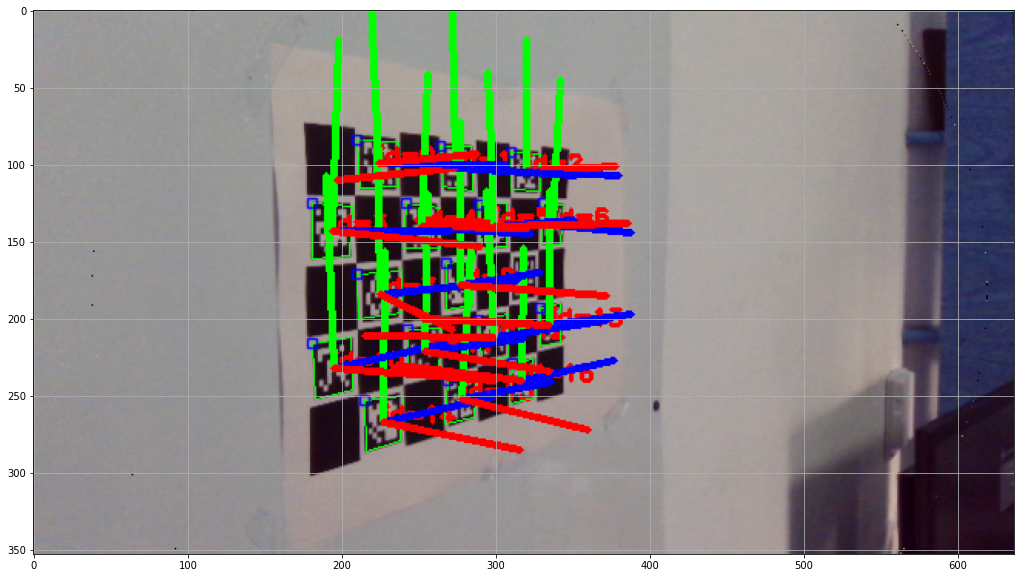

In [53]:
plt.figure(figsize=(20,10))
plt.imshow(imaxis)
plt.grid()
plt.show()

In [54]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"],
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data

,tx,ty,tz
marker,,,
0,-0.099555,-0.081111,0.572124
1,-0.056716,-0.085865,0.622736
2,-0.011750,-0.096682,0.723449
3,-0.111753,-0.034497,0.498181
4,-0.077988,-0.045224,0.613365
5,-0.031126,-0.046030,0.612676
6,0.007813,-0.050033,0.653645
7,-0.100864,-0.000623,0.583848
8,-0.050292,-0.006585,0.577078


In [55]:
datar = pd.DataFrame(data = tvecs.reshape(len(rvecs),3), columns = ["rx", "ry", "rz"],
                    index = ids.flatten())
datar.index.name = "marker"
datar.sort_index(inplace= True)
np.degrees(datar)

,rx,ry,rz
marker,,,
0,-5.704057,-4.647342,32.780291
1,-3.249565,-4.919687,35.680160
2,-0.673239,-5.539465,41.450557
3,-6.402952,-1.976517,28.543666
4,-4.468394,-2.591127,35.143253
5,-1.783409,-2.637336,35.103759
6,0.447657,-2.866707,37.451128
7,-5.779081,-0.035673,33.452052
8,-2.881493,-0.377304,33.064156


In [56]:
v = data.loc[3:6].values
((v[1:] - v[:-1])**2).sum(axis = 1)**.5

array([0.12050967, 0.04687384, 0.05666385])

In [57]:
cv2.Rodrigues(rvecs[0], np.zeros((3,3)))

(array([[ 0.59454872,  0.02230046,  0.80375028],
        [-0.0526218 , -0.99639314,  0.06657073],
        [ 0.80233582, -0.08187433, -0.59123077]]),
 array([[-0.22162214,  0.40902579,  0.1525893 , -0.41449374,  0.07430149,
          0.78446021,  0.13704206, -0.79282525,  0.29576571],
        [-0.00899414, -0.58661555,  0.02292908, -0.57876865,  0.01039789,
         -0.30186631, -0.03129412, -0.28631906, -0.0028182 ],
        [ 0.47640934,  0.1764526 , -0.35730443, -0.18481764,  0.03750098,
          0.41520173, -0.36515134, -0.4083178 , -0.43898807]]))

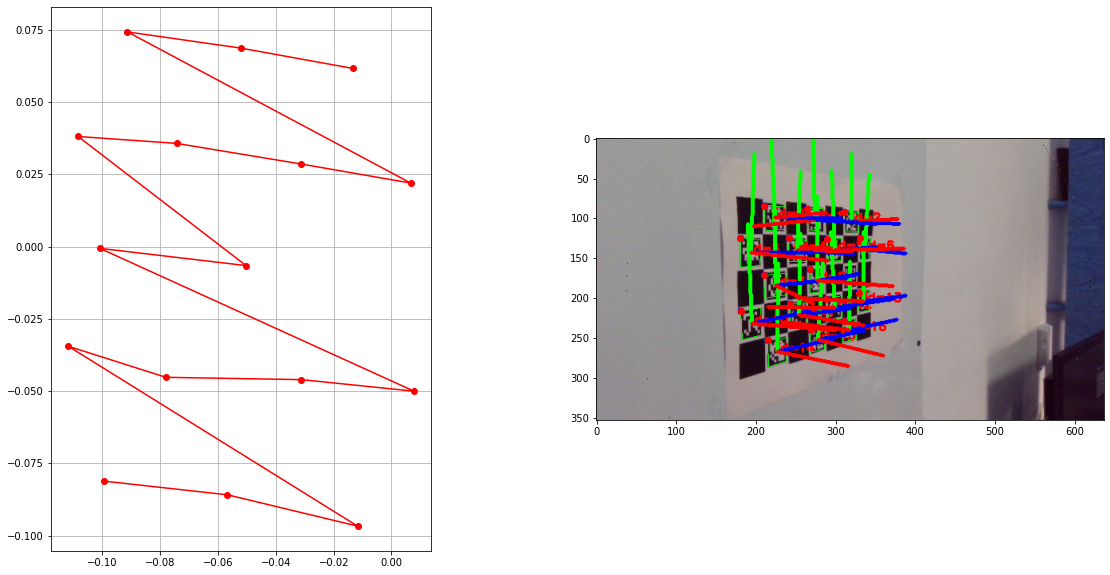

In [58]:
fig = plt.figure(figsize=(20,10))
#ax = fig.add_subplot(111, projection='3d')
ax = fig.add_subplot(1,2,1)
ax.set_aspect("equal")
plt.plot(data.tx, data.ty, "or-")
plt.grid()
ax = fig.add_subplot(1,2,2)
plt.imshow(imaxis, origin = "upper")
plt.plot(np.array(corners)[:, 0, 0,0], np.array(corners)[:, 0, 0,1], "or")
plt.show()